In [186]:
!pip install matplotlib

     |████████████████████████████████| 11.2 MB 409 kB/s  eta 0:00:01
     |████████████████████████████████| 965 kB 40.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 29.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 28.1 MB/s eta 0:00:01


In [187]:
import matplotlib
from matplotlib import pyplot

In [1]:
import numpy as np
import ujson
import pandas as pd
import itertools

In [2]:
import rasterio
import requests

In [18]:
from math import pi,sqrt,sin,cos,atan2

def haversine(pos1, pos2):
    lat1 = float(pos1[0])
    long1 = float(pos1[1])
    lat2 = float(pos2[0])
    long2 = float(pos2[1])

    degree_to_rad = float(pi / 180.0)

    d_lat = (lat2 - lat1) * degree_to_rad
    d_long = (long2 - long1) * degree_to_rad

    a = pow(sin(d_lat / 2), 2) + cos(lat1 * degree_to_rad) * cos(lat2 * degree_to_rad) * pow(sin(d_long / 2), 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    km = 6367 * c
    mi = 3956 * c

    return km

In [53]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    
    All args must be of equal length.    
    
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6378.137 * c
    return km

In [3]:
south_latmin = 43.7247599
north_latmax = 43.7519311
west_lonmin = 7.4090279
east_lonmax = 7.4398704

In [4]:
path = f'https://portal.opentopography.org/API/globaldem?demtype=COP30&south={south_latmin}&north={north_latmax}&west={west_lonmin}&east={east_lonmax}&outputFormat=GTiff&API_Key=demoapikeyot2022'
result = requests.get(path)

with open('monaco.geotiff','wb') as opened:
    opened.write(result.content)

In [5]:
import osrmbindings

In [6]:
osrmbindings.initialize('/3wheeler/monaco-latest')

In [7]:
st = pd.read_excel('data/customer_data.xlsx')

In [8]:
st

,N,lon,lat,id,fclass,Name,Zone,Demand,Time Windows
0,1,7.425203,43.732781,267901435,restaurant,Stars ‚Äôn‚Äô Bars,West,4,NaN
1,2,7.423927,43.732524,267901573,restaurant,Quai des Artistes,West,5,NaN
2,3,7.420386,43.732403,274500242,restaurant,Pizzeria Mon√©gasque,West,6,NaN
3,4,7.422148,43.733820,321647302,restaurant,Brasserie de Monaco,West,6,NaN
4,5,7.421410,43.733930,954710927,restaurant,Chez Edgar,West,3,NaN
...,...,...,...,...,...,...,...,...,...
82,83,7.429562,43.742286,7926333297,restaurant,Mozza,East,1,NaN
83,84,7.429690,43.742246,7926333298,restaurant,Cozza,East,4,NaN
84,85,7.430252,43.739527,8176182650,restaurant,Horizon Deck,East,6,NaN
85,86,7.428925,43.737572,8269648743,restaurant,Soci√©t√© Nautique,East,2,NaN


In [14]:
with rasterio.open('monaco.geotiff') as opened:
    alt = opened.read()[0] #only one channel to extract, result is a xy array

In [22]:
perms_iter = itertools.permutations(st.index, 2)

In [23]:
full_perms = list(perms_iter)

In [195]:
perms = full_perms

In [104]:
!pip install icecream

In [116]:
from icecream import ic

In [196]:
def calculate_elevation_costs(perms, customers):
    elevation_cost = np.zeros((len(st),len(st)))

    locations = customers[['lat','lon']].values
    
    with rasterio.open('monaco.geotiff') as src:
        for source, destination in perms:
            
            location1 = locations[source]
            location2 = locations[destination]
            lats = [location1[0], location2[0]]
            lons = [location1[1], location2[1]]
            
            response = osrmbindings.route(lons, lats)
            parsed = ujson.loads(response)
            coords = np.array(parsed['routes'][0]['geometry']['coordinates'])
            ys = coords[:,1]
            xs = coords[:,0]
            
            ys0 = ys[0:-1]
            ys1 = ys[1:]
            xs0 = xs[0:-1]
            xs1 = xs[1:]
            rows, cols = rasterio.transform.rowcol(src.transform, xs, ys)

            elevation_along_route = alt[rows,cols]

            distances = haversine_np(xs0, ys0, xs1, ys1)
            travelled = np.cumsum(distances)
            change = np.diff(elevation_along_route/1000)/distances # meters to km, elevation change per distance unit

            cost = np.max(change)
            elevation_cost[source, destination] = cost
        return elevation_cost

In [197]:
%%time
costs = calculate_elevation_costs(perms, st)

CPU times: user 17.7 s, sys: 0 ns, total: 17.7 s
Wall time: 17.7 s


In [150]:
%%timeit
costs = calculate_elevation_costs(perms, st)

649 ms ± 9.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


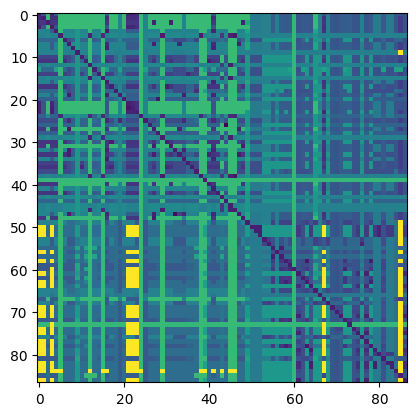

In [211]:
pyplot.imshow(costs)

In [213]:
np.save('elevation.costs.npy', costs)

In [30]:
!pip install line_profiler

     |████████████████████████████████| 675 kB 7.5 MB/s eta 0:00:01


In [31]:
%load_ext line_profiler

In [184]:
%lprun -f calculate_elevation_costs calculate_elevation_costs(perms, st)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import json
import argparse
import time

import build_time_dist_matrix
import optimization
import visualization
import schedule
import upload_results
import manual_viz



with open('data/config.json', 'r') as opened:
    config = json.load(opened)

In [ ]:

    
print(' *   Building Time/Distance Matrices')
#check if node_loader_options are specified
if 'node_loader_options' in config.keys():
    node_data = build_time_dist_matrix.process_nodes(config['node_loader_options'], config['zone_configs'])
else:
    node_data = build_time_dist_matrix.process_nodes()

print(f' *   Starting Model Run at {time.strftime("%H:%M:%S")} (UTC)')

routes_for_mapping_viz, vehicles_viz, zone_route_map = optimization.main(node_data, config)

visualization.main(routes_for_mapping_viz, vehicles_viz, zone_route_map)



In [ ]:
import datetime
import matplotlib
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [ ]:
pyplot.rcParams["figure.figsize"] = [3,7]
for route in route_dict:
    distances = [0]+route_dict[route]['current_distance'][:-1]
    times = route_dict[route]['time']
    distances = np.array(distances).cumsum()
    times = np.array(times)

    y_ticks = [f'{name} - {datetime.timedelta(seconds=float(one_time))}' for one_time,name in zip(times,route_dict[route]['current_names'])]
    pyplot.yticks(ticks=times, labels=y_ticks)
    pyplot.plot(distances, times, marker='o')
    pyplot.show()

In [ ]:
pyplot.rcParams["figure.figsize"] = [3,7]
for route in route_dict:
    distances = pd.Series(route_dict[route]['travel_time']).shift(1).values[1:]
    times = pd.Series(route_dict[route]['time']).diff()[1:]-150
    times = (times-distances)
    times = [int(t) for t in times]
    #distances = np.array(distances).cumsum()
    times = np.array(times)

    y_ticks = [f'{name[0]} to {name[1]} - {datetime.timedelta(seconds=float(one_time))}' for one_time,name in zip(times,zip(route_dict[route]['current_names'], route_dict[route]['next_names']))]
    pyplot.yticks(ticks=times, labels=y_ticks)
    pyplot.plot(times, marker='o')
    #pyplot.plot(distances, marker='o')
    pyplot.show()